# A Quick Introduction to PyTorch

PyTorch is one of the preeminent machine-learning and optimization libraries currently available. It contains a number of powerful features that drastically simplify the task of fitting models and training neural networks. While we won't have time in this tutorial to examine more than a few of the core features, there are many additional tutorials available online. This tutorial will roughly follow a few of the introductory PyTorch tutorials available at [pytorch.org/tutorials](https://pytorch.org/tutorials/).

In this tutorial, we'll be covering three topics, each briefly:
1. The basic structure of objects in PyTorch
2. Non-linear optimization
3. Neural Networks

## Basic PyTorch Data Structures

At first glance, PyTorch appears to be somewhat like NumPy in that it gives the user a set of classes and functions for interacting with a `Tensor` type that behaves much like NumPy's `ndarray` type. Both NumPy and PyTorch, for example, define functions like `log`, `sin`, and `mean` that work with their respective array type. However, the `Tensor` and `ndarray` objects aren't interchangeable. This is because PyTorch `Tensor`s are intended for use in optimization problems, and thus they track a wide variety of data about what computations they have been used in. These data are critical for performing efficient gradient-descent parameter-tuning, which is generally required for optimization and for training neural networks.

Let's start by importing a number of PyTorch modules for use in this tutorial.

In [2]:
# Import the PyTorch library:
import torch
# Import the Neural-Network sub-module of PyTorch:
from torch import nn
# The DataLoader class is a helper for loading datasets during model training:
from torch.utils.data import DataLoader
# The datasets sub-module of the torchvision library, which contains tools
# related to computer vision, will let us load existing public datasets
# for use in this tutorial. You can see the full list of datasets that are
# supported here: https://pytorch.org/vision/stable/datasets.html
from torchvision import datasets
# The ToTensor, Lambda, and Compose classes are commonly used in neural network
# layers to transform data. They will be explained when they are used below.
from torchvision.transforms import ToTensor, Lambda, Compose

# Finally, we want to import matplotlib.pyplot so that we can visualize the
# results of our training.
import matplotlib.pyplot as plt

### PyTorch Tensors

Most of PyTorch revolves around a single datatype, the PyTorch `Tensor` (`torch.Tensor`). At first glance, the tensor class seems almost identical to NumPy's `ndarray` class. However, although they share many similarities, the two types are not directly compatible. The main difference between them is that tensors track a variety of data that can be used to calculate gradients. Let's take a look at the `torch.Tensor` type here.

In [24]:
# The torch library uses many of the same conventions as the numpy library.
u = torch.zeros((10, 3))  # Make a 10x3 matrix.

u[:,0] = 1 # Assign the first column to have values of 1.

u = (u - 0.5) *  3.0 # Subtract 1/2 then multiply the tensor by 3.

print(u) # Print the tensor.

tensor([[ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000],
        [ 1.5000, -1.5000, -1.5000]])


In [82]:
# Note that we will sometimes get an error if we try to use numpy arrays and
# tensors interchangeably. Although some operations like this may work, you
# should generally work with one or the other and not try to mix them.
import numpy as np

a = np.zeros((10,3))

torch.mean(a)

TypeError: mean(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [28]:
# However, if you need to extract a numpy array from a tensor, you can
# use first detach the tensor (i.e., remove it from the backend system
# that keeps track of gradients) then request the numpy representation.
a = u.detach().numpy()
print(type(a))
print(a)

<class 'numpy.ndarray'>
[[ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]
 [ 1.5 -1.5 -1.5]]


One of the really great things about PyTorch is that it can easily find the gradient of a particular calculation. Let's look at this via an example in which we use PyTorch to calculate the point along a 2D curve that is closest to the point `(0,0)`.

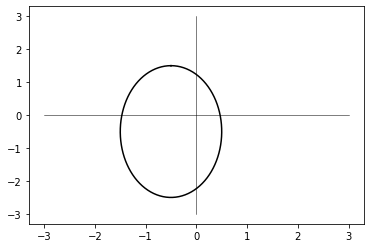

In [44]:
# To start with, let's define the curve itself; we define this as a
# parametric curve s(t) = (x(t), y(t)):
def curve(t):
    return (torch.sin(t) - 0.5, torch.cos(t)*2 - 0.5)

# Let's see what this curve looks like:
t = torch.linspace(0, np.pi*2, 100)
(x,y) = curve(t)

# Plot these points as a curve:
plt.plot(x, y, 'k-')
# Also plot the x and y axes:
plt.plot([-3,3], [0,0], 'k-', lw=0.5)
plt.plot([0,0], [-3,3], 'k-', lw=0.5);

In [46]:
# The goal is to find the point closest to (0,0). This minimizes the
# distance between (0,0) and (x(t), y(t)). Let's define this as the
# loss function (i.e., the quantity we are minimizing).
def loss(t):
    (x,y) = curve(t)
    return torch.sqrt((x - 0)**2 + (y - 0)**2)

# We can calculate the loss for any value of t:
t = torch.tensor(1.5)
dist = loss(t)
dist

tensor(0.6132)

Notice that the loss function doesn't return a Python floating-point number; rather it returns a PyTorch tensor object containing just a floating point number. This is because, although this value will act like a floating point number, it also contains extra information about how it was calculated. We can, in fact, use this to determine the gradient of `curve(t)` at the point `t`. For this to work, we just need to specify that our input tensor requires that gradient calculations be tracked:

In [50]:
t = torch.tensor(1.5, requires_grad=True)
dist = loss(t)

# Run the backward gradient routine to calculate the gradients:
dist.backward()
t.grad

tensor(1.2238)

This combination of calling `output.backward()` then examining the `input.grad` value works not just for single values, but also for high-dimensional tensors, and PyTorch is very efficient about calculating these gradients.

Because we can calculate the gradient for our loss function, we can minimize the loss by using a simple gradient descent optimizer.

In [66]:
# We want to start the minimization with t equal to this value:
t = torch.tensor(1.5, requires_grad=True)

# Declare an optimizer (SGD: stochastic gradient descent).
# We are minimizing over the argument t (i.e., the input), and
# we provide a low learning-rate (which affects how big the
# optimizer's steps are).
optimizer = torch.optim.SGD([t], lr=0.05)

# Now we can take several steps to see if the optimizer converges.
for step_number in range(20): # we'll take 20 steps...
    # We're starting a new step, so we reset the gradients.
    optimizer.zero_grad()
    dist = loss(t)
    print("Step number", step_number,
          "  t = ", float(t),
          "  loss = ", float(dist))
    dist.backward()
    optimizer.step()

print(t, loss(t))

Step number 0   t =  1.5   loss =  0.6132225394248962
Step number 1   t =  1.4388113021850586   loss =  0.5453901290893555
Step number 2   t =  1.3898437023162842   loss =  0.503545343875885
Step number 3   t =  1.353838562965393   loss =  0.4815952479839325
Step number 4   t =  1.329099178314209   loss =  0.4714145064353943
Step number 5   t =  1.3127572536468506   loss =  0.4670073986053467
Step number 6   t =  1.3021482229232788   loss =  0.4651552140712738
Step number 7   t =  1.2953016757965088   loss =  0.4643843173980713
Step number 8   t =  1.290889024734497   loss =  0.4640641212463379
Step number 9   t =  1.2880440950393677   loss =  0.4639309346675873
Step number 10   t =  1.2862088680267334   loss =  0.46387556195259094
Step number 11   t =  1.2850241661071777   loss =  0.4638524353504181
Step number 12   t =  1.2842590808868408   loss =  0.46384280920028687
Step number 13   t =  1.2837648391723633   loss =  0.46383875608444214
Step number 14   t =  1.2834454774856567   los

Let's plot the solution we found!

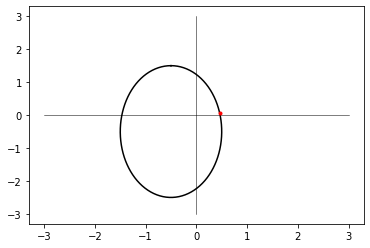

In [67]:
# The points that we found in the search above:
(x0,y0) = curve(t)
# We will need to detach these values to plot them because they were
# calculated using t, which requires gradients be tracked.
x0 = x0.detach().numpy()
y0 = y0.detach().numpy()

# Plot all the points in the curve:
(x,y) = curve(torch.linspace(0, np.pi*2, 100))
plt.plot(x, y, 'k-')
# Also plot the x and y axes:
plt.plot([-3,3], [0,0], 'k-', lw=0.5)
plt.plot([0,0], [-3,3], 'k-', lw=0.5)
# And finally plot the point we found.
plt.plot(x0, y0, 'r.');

## Training a Neural Network to recognize clothes

The remainder of this tutorial provides an example walkthrough of how to train a neural network using PyTorch. We will use a public dataset, the Fashion MNIST dataset, and we will setup a simple neural network that can be trained to recognize the type of clothing in a small (28x28) image from a list of 10 clothing types.

### The Fashion MNIST Dataset

For this tutorial we'll be using the Fashion MNIST dataset, which contains images of various clothing items, each of which has been labeled as a type of clothing. The dataset is available on Amazon's S3 service, but the `torchvision.datasets` module that we imported above has a class that will manage the dataset for us.

In [68]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data", # The directory we store the data in.
    train=True,
    download=True,
    transform=ToTensor(), # Transform the images to PyTorch tensors.
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

(Note that when you run the above cell, you may get a warning about writeable NumPy arrays; this can be safely ignored.)

We now have a representation of this dataset in the variables `training_data` and `test_data`. Naturally, these will correspond to our training and testing datasets; these are independent in order to avoid overfitting.

PyTorch typically expects to interact with trainig and testing data via a class called `DataLoader`, which we imported earlier, from the `torch.utils.data` module. This class manages the loading and caching of individual data samples from our datasets, and can even perform loading in parallel if the dataset is large and cumbersome enough. In this cell, we setup data loaders for the two datasets and demonstrate how they work.

In [21]:
# Training data usually arrives to the model-fitting routine as 
# a batch of samples. This sets the size of each batch.
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# 
for X, y in test_dataloader:
    print("Shape of X [Batch-Size, Image-Channels, Height, Width]: ")
    print("     ", X.shape, X.dtype)
    print("Shape of y [1 Label per Batch]: ")
    print("     ", y.shape, y.dtype)
    break

Shape of X [Batch-Size, Image-Channels, Height, Width]: 
      torch.Size([64, 1, 28, 28]) torch.float32
Shape of y [1 Label per Batch]: 
      torch.Size([64]) torch.int64


Notice that when we loop over the `test_dataloader` object, it yields a sequence of `(X,y)` tuples where `X` is a tensor of clothing images from the Fashion MNIST dataset and `y` is a list of the corresponding integer labels. Notice that the first dimension of both `X` and `y` is 64, which is also our training batch size--i.e., the dataloaders always yield data samples in batches. Notice also that the second dimension of the `X` value is 1; this is because the images are grayscale and thus have only one color-channel. The final two dimensions are the height and width of the image.

The `y` labels that are returned are just integers, 0-9, corresponding to a clothing-type label. Our goal is to train a neural network to look at the images in `X` and to predict the image labels in `y`. To add some color, however, let's go ahead and declare what each of the `y` labels correspond to (this is encoded as part of the dataset and can be found at the [Fashion MNIST GitHub page](https://github.com/zalandoresearch/fashion-mnist)).

In [16]:
fashionMNIST_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

Now, let's see if we can verify that these labels are correct by looking at a few of the images.

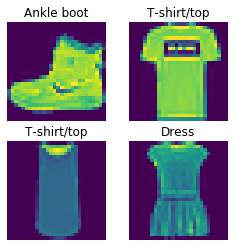

In [18]:
# We'll and label 4 images in a 2x2 grid:
(fig, axs) = plt.subplots(2, 2, figsize=(4,4))
axs = axs.flatten()

# Get one batch of samples from the dataloader--remember that this
# batch will have 64 images in it.
for (X_batch,y_batch) in train_dataloader:
    # Go ahead and plot the first four of these images
    for (ax,X,y) in zip(axs, X_batch, y_batch):
        ax.imshow(X[0])
        ax.set_title(fashionMNIST_labels[y])
        ax.axis('off')
    break

### Defining and training the Network

The next step for our neural network project is to define the neural network itself.

PyTorch makes defining neural network models fairly easy. You simply need to declare a Python class that inherits from the `torch.nn.Module` class, which represents a single module of a neural network. Because a module can itself contain a number of network layers, the module can either represent a piece of a network or it can be the entire neural network.

When declaring a `Module`, we need to make sure to define the stack of layers in the network in the class's constructor (the `__init__()` method), and we need to declare how the model is calculated in the class's `forward()` method.

In [63]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


As we can see, this network is a stack of a few operators. First of all, we have a layer that flattens the inputs from 28x28 images into 784-element vectors. Next, we have a sub-stack of layers that consists of three [linear operators](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), each of which is rectified by a [rectified linear unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

We aren't going to worry too much about what these particular layers of the network are doing. Suffice to say that these are fairly common components of neural networks, and that a full discussion of common neural network layers is beyond the scope of this tutorial.

One other thing to note is that the `out_features` of the final linear operator in the stack is 10. This means that the output is in fact a 10-dimensional tensor (like a numpy array whose shape is `(10,)`). Typically when performing this kind of classification problem we interpret each of the output dimensions as representing the likelihood of an input to the model belonging to one of the dataset classes, so if the output features for a particular image are `[0, 0.1, 0, 0.01, 0.5, 0.3, 0.2, 0, 0,3]`, we interpret the model as predicting that the image belongs to class 4 (because `output[4]` is 0.5, which is the largest value in the outputs). In short, we can convert the output feature tensor into a predicted class number by taking the `argmax` of the output tensor.

---

In order to train the above neural network, we will need to define a loss function that we are trying to minimize. In this case, we can use a builtin loss function called [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). We won't discuss the details of how this loss function works, but it is commonly used with classification problems like the one we are encoding here.

We'll also need an optimizer, and in this case we'll use the same optimizer we used above: SGD (stochastic gradient descent).  Because our model was written using the `torch.nn.Module` class, we can get all of the model parameters by calling the `model.parameters()` method.

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

To perform the training itself, we just need to step through the data-items in the training dataset and provide them each to the optimizer, much like we did in the simpler optimization example above.

In [74]:
# Get the size of the training dataset.
size = len(train_dataloader.dataset)

# Walk through each training batch:
for (batch_num, (X, y)) in enumerate(train_dataloader):
    # Compute prediction:
    pred = model(X)
    # And compute the loss of that prediction:
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out a status message every so often.
    if batch_num % 100 == 0:
        (loss, current) = (loss.item(), batch_num * len(X))
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

loss: 2.297015  [    0/60000]
loss: 2.286880  [ 6400/60000]
loss: 2.280019  [12800/60000]
loss: 2.282588  [19200/60000]
loss: 2.259491  [25600/60000]
loss: 2.249367  [32000/60000]
loss: 2.237668  [38400/60000]
loss: 2.221228  [44800/60000]
loss: 2.229277  [51200/60000]
loss: 2.223324  [57600/60000]


Okay, it appears that the above cell worked, but what did it do? We can see from the printed lines that as the optimization proceeded, the loss decreased (though the total decrease in the loss was only about 0.075). If we want to see how well this fitting procedure worked, we can look at some examples from the test dataset and see how well the trained model performs. For this, we can essentially copy-and-paste the code-block above that we used to look at the initial images and labels.

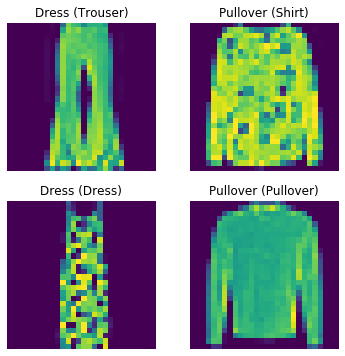

In [81]:
# We'll and label 4 images in a 2x2 grid:
(fig, axs) = plt.subplots(2, 2, figsize=(6,6))
axs = axs.flatten()

# Get one batch of samples from the dataloader--remember that this
# batch will have 64 images in it.
for (X_batch,y_batch) in test_dataloader:
    # We want a random set of 4 images each time, so we keep drawing
    # new image batches until we randomly draw a number over 0.9:
    if np.random.rand() < 0.9: continue
    # Go ahead and plot the first four of these images
    for (ax,X,y) in zip(axs, X_batch, y_batch):
        ax.imshow(X[0])
        # Get the model's prediction for this particular image:
        pred = model(X)
        # Convert the predicted tensor into a single label:
        label = torch.argmax(pred)
        # If that label is equal to y, the network got it right;
        # otherwise, it got it wrong!
        y_name = fashionMNIST_labels[y]
        label_name = fashionMNIST_labels[label]
        ax.set_title(label_name + " (" + y_name + ")")
        ax.axis('off')
    break

Clearly, our network isn't perfect--if you run the above cell many times, you will see that sometimes the network gets the item type correct, and sometimes it gets it wrong. However, you might also nitce that when the network is wrong, it is wrong in a fairly understandable way (for example, bell-bottom jeans might be labeled as a dress, and a shirt might be labeled as a pullover). This shouldn't be too surprising, considering that we trained a fairly small neural network with a simple architecture, but hopefully this example demonstrates the fundamentals of how PyTorch organizes models and networks used for machine learning.

## Additional References

Additional PyTorch materials can be found primarily at [pytorch.org](https://pytorch.org/) (note specifically the [Docs](https://pytorch.org/docs/) and [Tutorials](https://pytorch.org/tutorials/) links at the top of the page). You may also want to check out PyTorch's [60-minute blitz video tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).